In [18]:
import os,requests,folium
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from folium import plugins
from math import asin,atan,atan2,cos,degrees,radians,sin,pi
from statistics import mean
pd.set_option('display.max_columns',None)

### Get Data

In [19]:
a_req = requests.get('https://avalanche.state.co.us/sites/default/files/2022-11/Accidents_2022_PUBLIC.xlsx')
df = pd.read_excel(a_req.content)
df = df.replace('SKi','Ski')
df = df.replace(['Mechanised Guide','Motorized Guided client','Mechanized Guide'],'Mechanized Guiding Client')
df[['lon','lat']] = df[['lon','lat']].fillna(0)
df['Date'] = df.Date.dt.date
pdf = df[(df.lat != 0) & (df.lon != 0)]
pdf.reset_index()
print(f'Entities of Full Dataset: {len(df)}\nEntities of Dataset with Lat/Lon: {len(pdf)}')

Entities of Full Dataset: 956
Entities of Dataset with Lat/Lon: 297


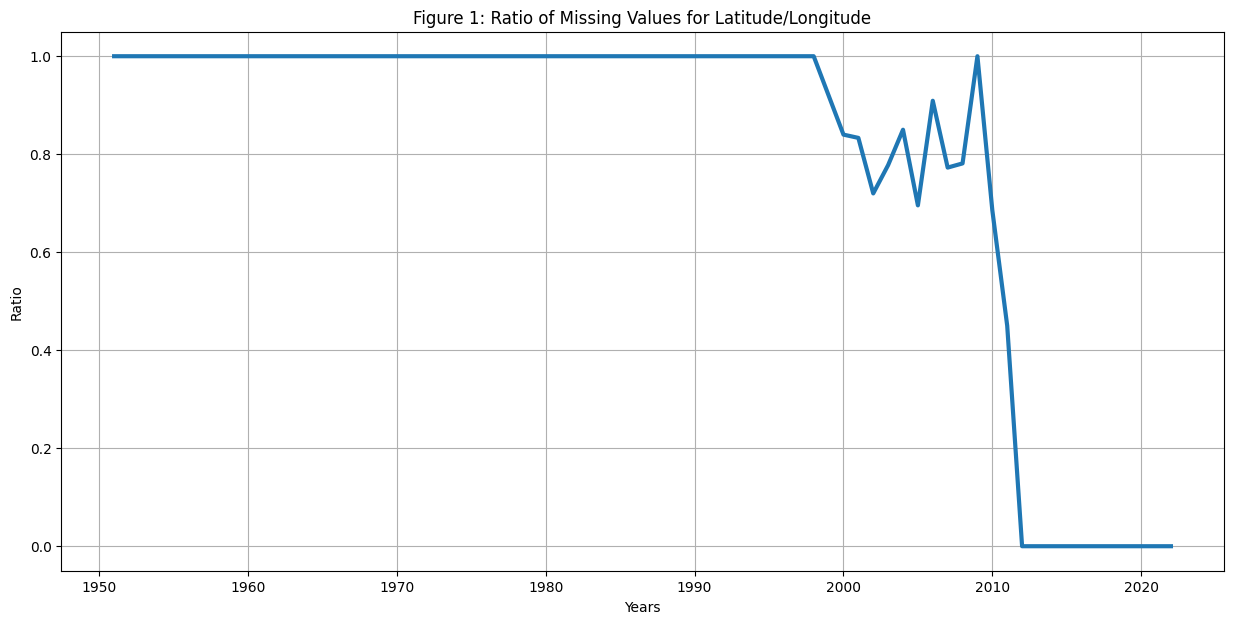

In [20]:
ydf = df.groupby('YYYY')['lat']
years = []
nulls = []
for y,d in ydf:
  years.append(y)
  nulls.append(sum(d == 0.0)/len(d))

plt.figure(figsize=(15,7))
plt.plot(years,nulls,lw=3)
plt.title('Figure 1: Ratio of Missing Values for Latitude/Longitude')
plt.xlabel('Years')
plt.ylabel('Ratio')
plt.grid()
plt.savefig('./data/missing_lat.png')



### Get Elevation
[USGS Elevation](https://apps.nationalmap.gov/epqs/)

**This Takes Sometime (~3mins)**

In [21]:
def getEle(elat,elon):
  el_url = r'https://epqs.nationalmap.gov/v1/json?'
  el_pars = {
    'output':'json',
    'x':elon,
    'y':elat,
    'units':'Meters'
  }    
  rtn = requests.get(el_url,el_pars).json()['value']
  return float(rtn)
   

In [5]:
elst = []
for tpl in zip(pdf.lat,pdf.lon):
  lat = tpl[0]
  lon = tpl[1]
  elst.append(getEle(lat,lon))
pdf = pdf.assign(Elevation=elst)

### Get Weather
[Open-Metro Weather API](https://open-meteo.com/en/docs/)

Get day of data


**This Takes Sometime (~3mins)**

In [6]:
w_url = 'https://archive-api.open-meteo.com/v1/archive'
precip = []
wind_max = []
atemp_max = []
atemp_min = []
atemp_avg = []
for i,r in enumerate(pdf.iterrows()):
  w_pars = {
    'timezone':'auto',
    'latitude':r[1].lat,
    'longitude':r[1].lon,
    'start_date':r[1].Date,
    'end_date':r[1].Date,
    'daily':['precipitation_sum','apparent_temperature_max','apparent_temperature_min','windspeed_10m_max'],
  }
  w_dat = requests.get(w_url,params=w_pars).json()['daily']
  precip.append(w_dat['precipitation_sum'][0])
  wind_max.append(w_dat['windspeed_10m_max'][0])
  atemp_max.append(w_dat['apparent_temperature_max'][0])
  atemp_min.append(w_dat['apparent_temperature_min'][0])
  atemp_avg.append((w_dat['apparent_temperature_max'][0]+w_dat['apparent_temperature_min'][0])/2)
pdf['precipitation_sum'] = precip
pdf['windspeed_max'] = wind_max
pdf['apparent_temperature_max'] = atemp_max
pdf['apparent_temperature_min'] = atemp_min
pdf['apparent_temperature_avg'] = atemp_avg


Get aggregated data of previous week (7 Days)

**This Takes Sometime (~3min)**

In [7]:
precip7d = []
atemp_max7d = []
atemp_min7d = []
atemp_avg7d = []
for i,r in enumerate(pdf.iterrows()):
  w_pars = {
    'timezone':'auto',
    'latitude':r[1].lat,
    'longitude':r[1].lon,
    'start_date':str(pd.to_datetime(r[1].Date) - pd.Timedelta(days=7)).split()[0],
    'end_date':r[1].Date,
    'daily':['precipitation_sum','apparent_temperature_max','apparent_temperature_min'],
  }
  w_dat = requests.get(w_url,params=w_pars).json()['daily']
  precip7d.append(sum(w_dat['precipitation_sum']))
  atemp_max7d.append(max(w_dat['apparent_temperature_max']))
  atemp_min7d.append(min(w_dat['apparent_temperature_min']))
  atemp_avg7d.append(mean([(w_dat['apparent_temperature_max'][idx]+w_dat['apparent_temperature_min'][idx])/2 for idx in range(7)]))
pdf['precipitation_sum_7d'] = precip7d
pdf['apparent_temperature_max_7d'] = atemp_max7d
pdf['apparent_temperature_min_7d'] = atemp_min7d
pdf['apparent_temperature_avg_7d'] = atemp_avg7d


### Get Geo

In [8]:
geo_us = gpd.read_file('https://raw.githubusercontent.com/python-visualization/folium/main/tests/us-states.json')
gdf = pd.merge(pdf,geo_us,left_on='State',right_on='id',how='left')

### Get Map


In [9]:
m = folium.Map(
  location=[39,-105],
  zoom_start=3,
  tiles='stamenterrain'
)
m.add_child(plugins.MiniMap(toggle_display=True))
mrks = plugins.MarkerCluster().add_to(m)
clrs = ['white','lightcoral','tomato','orangered','red','firebrick','darkred']
for r in gdf.iterrows():
  coord = [r[1]['lat'],r[1]['lon']]
  desc = r[1]['Description'] if type(r[1]['Description']) == str else "No Description"
  folium.Marker(
    location=coord,
    tooltip=f'Deaths: {r[1]["Killed"]}',
    popup=folium.Popup(folium.IFrame(
      f"Date: {r[1]['Date']}<br>State: {r[1]['State']}<br>Activity: {r[1]['PrimaryActivity']}<br><br>Description: {desc}"
    ),min_width=250,max_width=500),
    icon=plugins.BeautifyIcon(
      icon_shape='marker',
      border_color='red',
      background_color=clrs[r[1]['Killed']],
      text_color='black',
      number=r[1]['Killed'],
    )
   ).add_to(mrks)
ncltr = [str(n) for n in range(len(gdf))]

folium.GeoJson(gpd.GeoDataFrame(gdf.iloc[:,-3:]),style_function=lambda x:{'fillColor':'white','fillOpacity':0,'color':'black','weight':2}).add_to(m)
m

### Get Plots

All Deaths (including missing location)

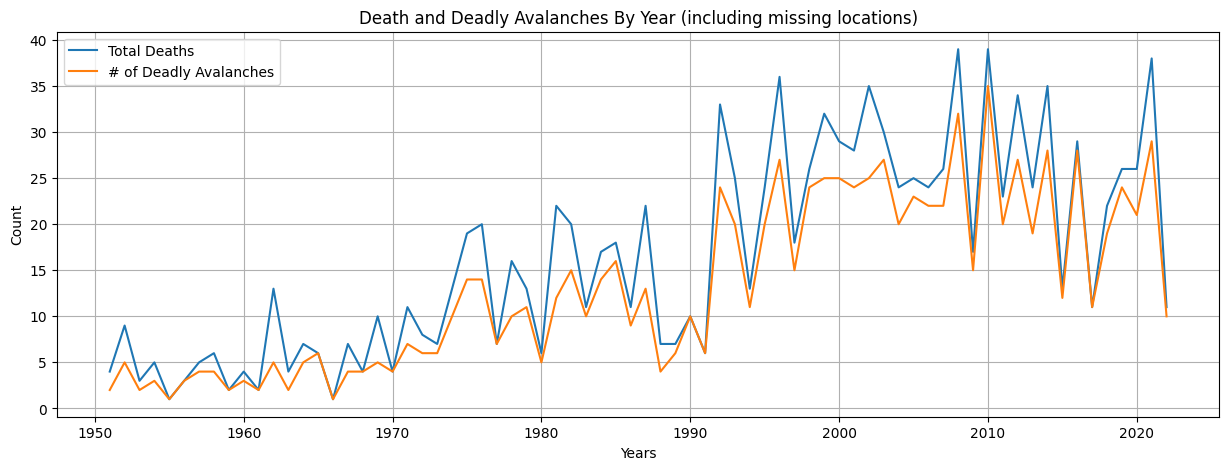

In [10]:
dead = df.groupby('YYYY')['Killed'].sum()
avlc = df.groupby('YYYY')['Killed'].count()
plt.figure(figsize=(15,5))
plt.plot(dead,label='Total Deaths')
plt.plot(avlc,label='# of Deadly Avalanches')
plt.title('Death and Deadly Avalanches By Year (including missing locations)')
plt.xlabel('Years')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.savefig('./data/fig1.png')


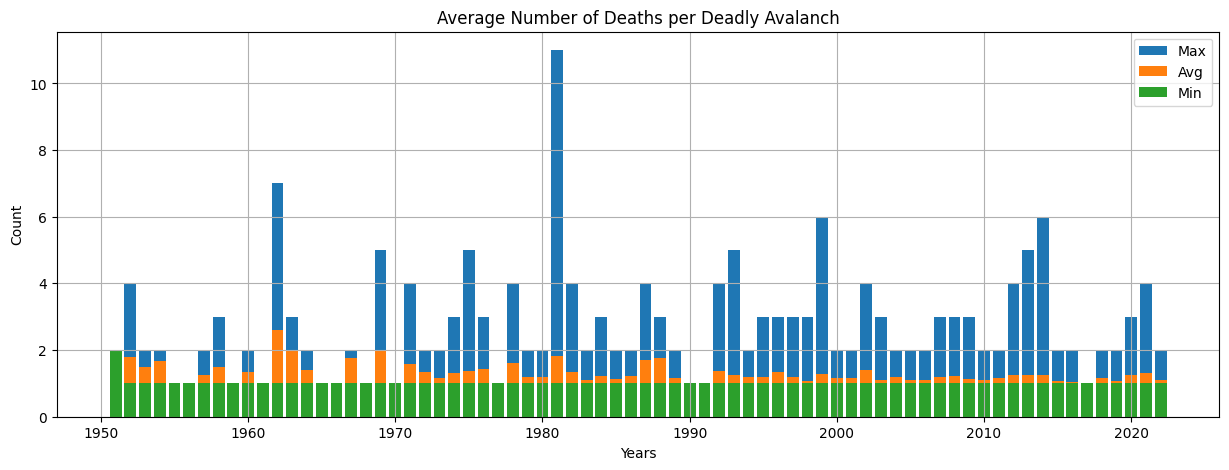

In [11]:
avg = dead/avlc
dmin = df.groupby('YYYY')['Killed'].min()
dmax = df.groupby('YYYY')['Killed'].max()
plt.figure(figsize=(15,5))
plt.bar(dead.index,dmax,label='Max')
plt.bar(dead.index,avg,label='Avg')
plt.bar(dead.index,dmin,label='Min')
plt.title('Average Number of Deaths per Deadly Avalanch')
plt.xlabel('Years')
plt.ylabel('Count')
plt.legend()
plt.grid()


[Mt Rainier Avalanche](https://www.historylink.org/file/10796)

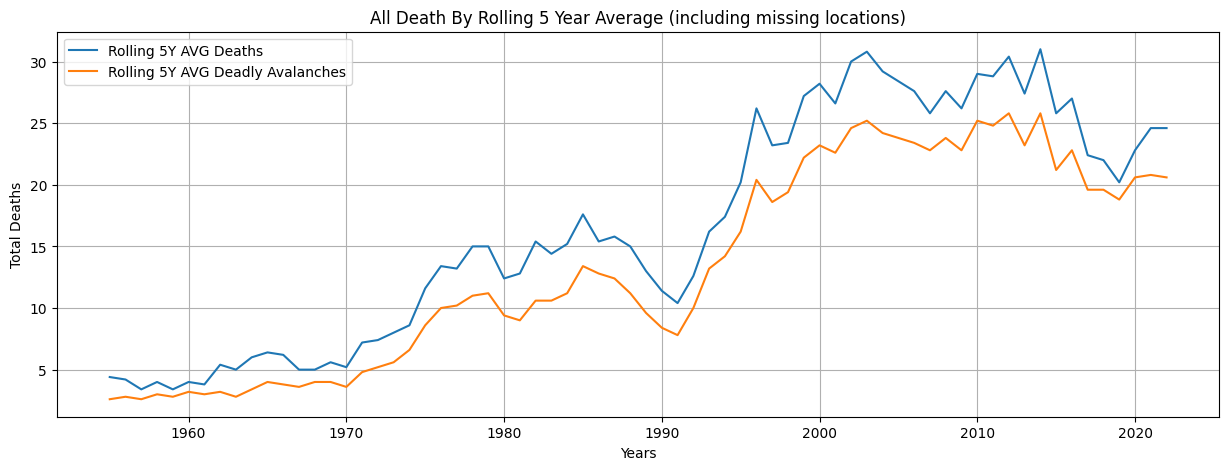

In [12]:
rdead = df.groupby('YYYY')['Killed'].sum().rolling(5).mean()
ravlc = df.groupby('YYYY')['Killed'].count().rolling(5).mean()
plt.figure(figsize=(15,5))
plt.plot(rdead,label='Rolling 5Y AVG Deaths')
plt.plot(ravlc,label='Rolling 5Y AVG Deadly Avalanches')
plt.title('All Death By Rolling 5 Year Average (including missing locations)')
plt.xlabel('Years')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid()


By States

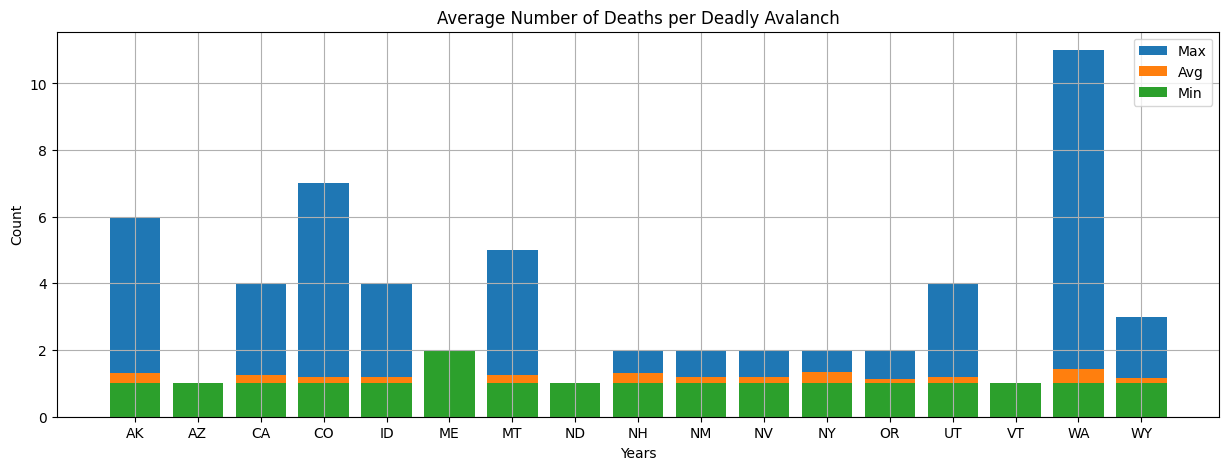

In [13]:
avg = df.groupby('State')['Killed'].sum()/df.groupby('State')['Killed'].count()
dmin = df.groupby('State')['Killed'].min()
dmax = df.groupby('State')['Killed'].max()
plt.figure(figsize=(15,5))
plt.bar(avg.index,dmax,label='Max')
plt.bar(avg.index,avg,label='Avg')
plt.bar(avg.index,dmin,label='Min')
plt.title('Average Number of Deaths per Deadly Avalanch')
plt.xlabel('Years')
plt.ylabel('Count')
plt.legend()
plt.grid()


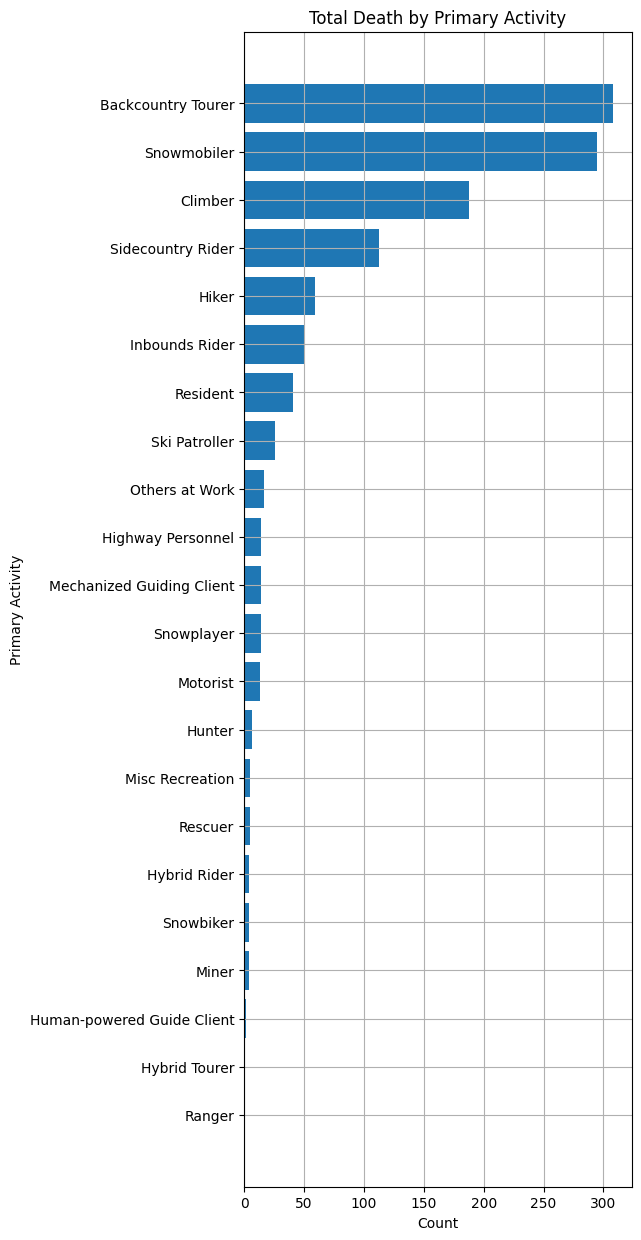

In [14]:
act = df.groupby('PrimaryActivity')['Killed'].sum().sort_values()
plt.figure(figsize=(5,15))
plt.barh(act.index,act)
plt.title('Total Death by Primary Activity')
plt.xlabel('Count')
plt.ylabel('Primary Activity')
plt.grid()

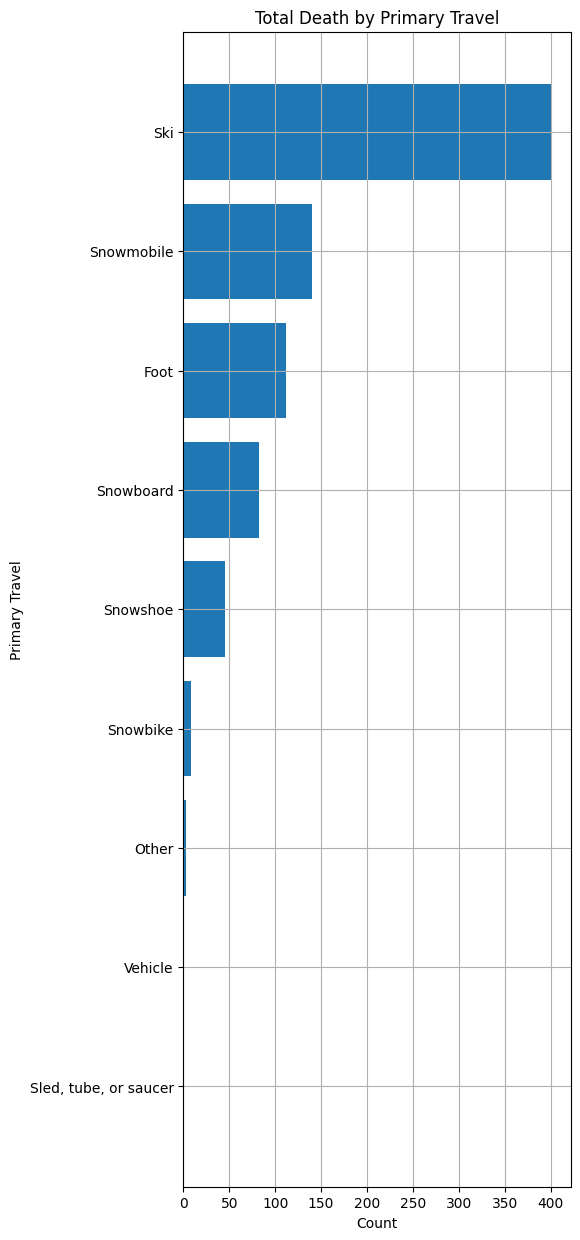

In [15]:
tvl = df.groupby('TravelMode')['Killed'].sum().sort_values()
plt.figure(figsize=(5,15))
plt.barh(tvl.index,tvl)
plt.title('Total Death by Primary Travel')
plt.xlabel('Count')
plt.ylabel('Primary Travel')
plt.grid()

In [16]:
pdf.isna().sum()

AvyYear                          0
YYYY                             0
MM                               0
DD                               0
Location                         0
Trigger                        212
D Size                         229
Setting                          0
State                            0
lat                              0
lon                              0
PrimaryActivity                  0
TravelMode                      15
Killed                           0
Description                     93
Date                             0
Elevation                        0
precipitation_sum                0
windspeed_max                    0
apparent_temperature_max         0
apparent_temperature_min         0
apparent_temperature_avg         0
precipitation_sum_7d             0
apparent_temperature_max_7d      0
apparent_temperature_min_7d      0
apparent_temperature_avg_7d      0
dtype: int64

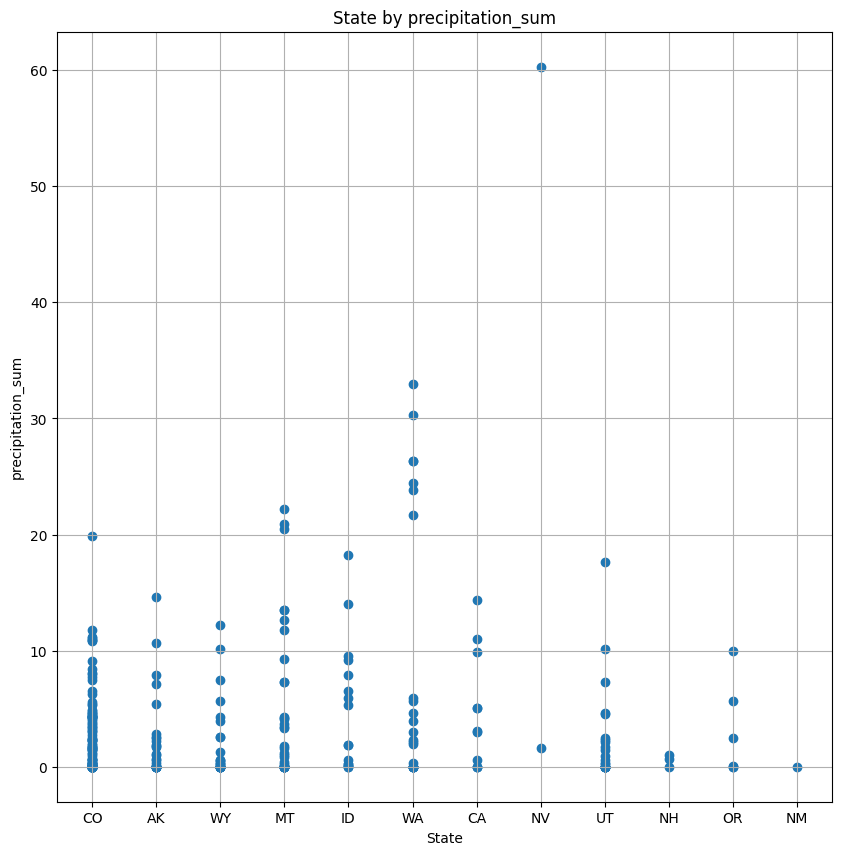

In [17]:
x = 'State'
y = 'precipitation_sum'
plt.figure(figsize=(10,10))
plt.scatter(pdf[x],pdf[y])
plt.title(f'{x} by {y}')
plt.xlabel(x)
plt.ylabel(y)
plt.grid()


In [28]:
pdf.head()

from prettytable import PrettyTable
import plotly.express as px

killed = df.groupby(df.AvyYear)['Killed'].sum()
killeddf = pd.DataFrame(killed)

fig = px.bar(killeddf, y="Killed",
              color = 'Killed',
              title='Killed by Year')
fig.show()

